In [6]:
#RUN FIRST

curr_dir = f'/user_data/csimmon2/git_repos/ptoc'

import sys
sys.path.insert(0,curr_dir)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb
import ptoc_params as params

from plotnine import *

#hide warnings
import warnings
warnings.filterwarnings('ignore')

#load additional libraries
from nilearn import image, plotting, input_data, glm
from nilearn.input_data import NiftiMasker
import nibabel as nib
import statsmodels.api as sm
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template
from nilearn.glm.first_level import compute_regressor 

suf = params.suf
#mni = load_mni152_brain_mask()



'''exp info'''
#load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()

study = 'ToolLoc'
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
exp = ''
#control_tasks = ['loc']
file_suf = ''

data_dir = params.data_dir
fig_dir = params.fig_dir
task_info = params.task_info
raw_dir = params.raw_dir

'''scan params'''
tr = 1 #toolloc_params
vols = 341 #toolloc_params

whole_brain_mask = load_mni152_brain_mask()
mni = load_mni152_template()
brain_masker = NiftiMasker(whole_brain_mask, smoothing_fwhm=0, standardize=True)

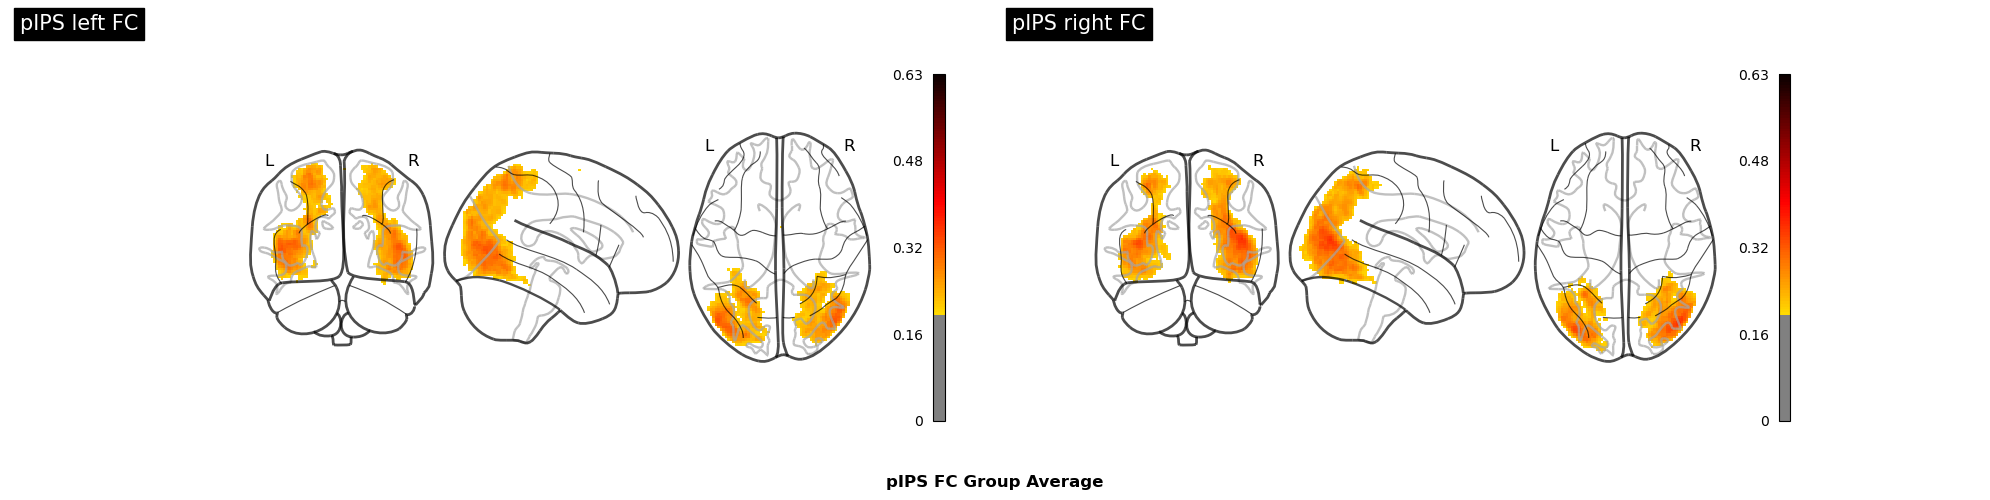

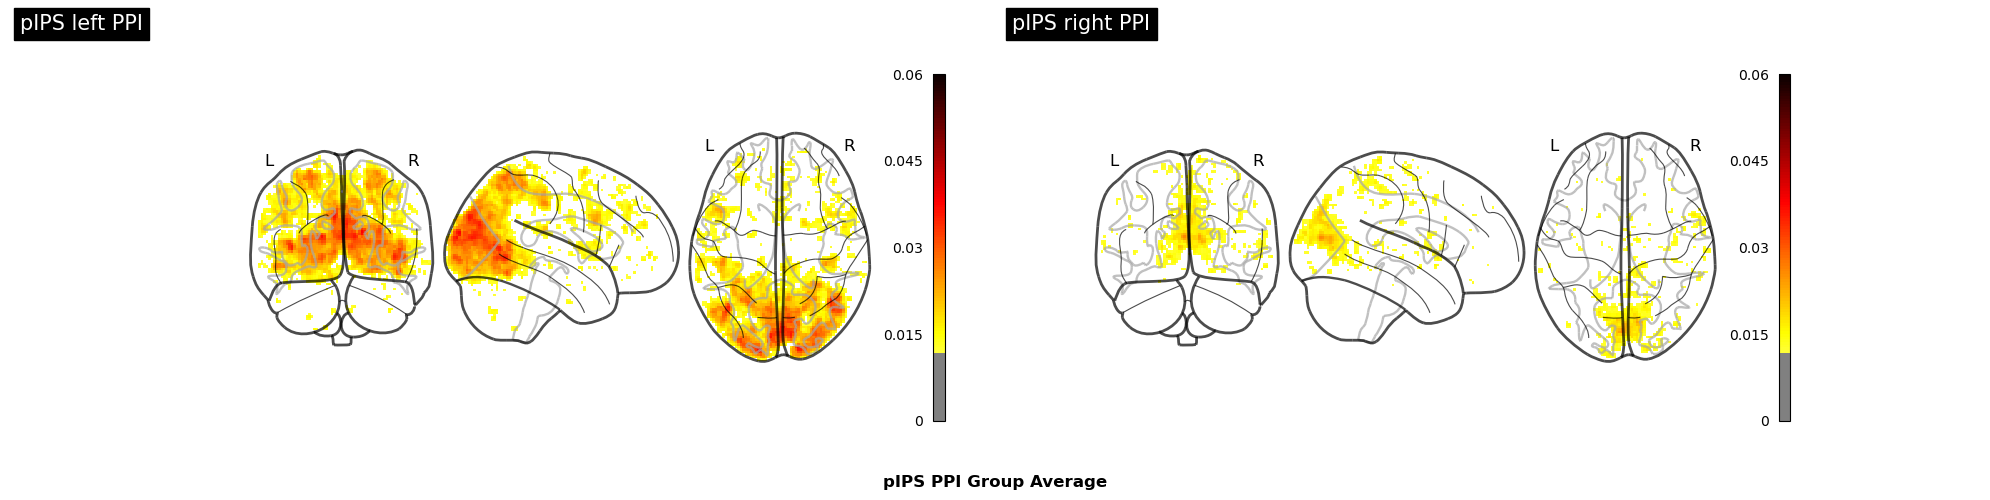

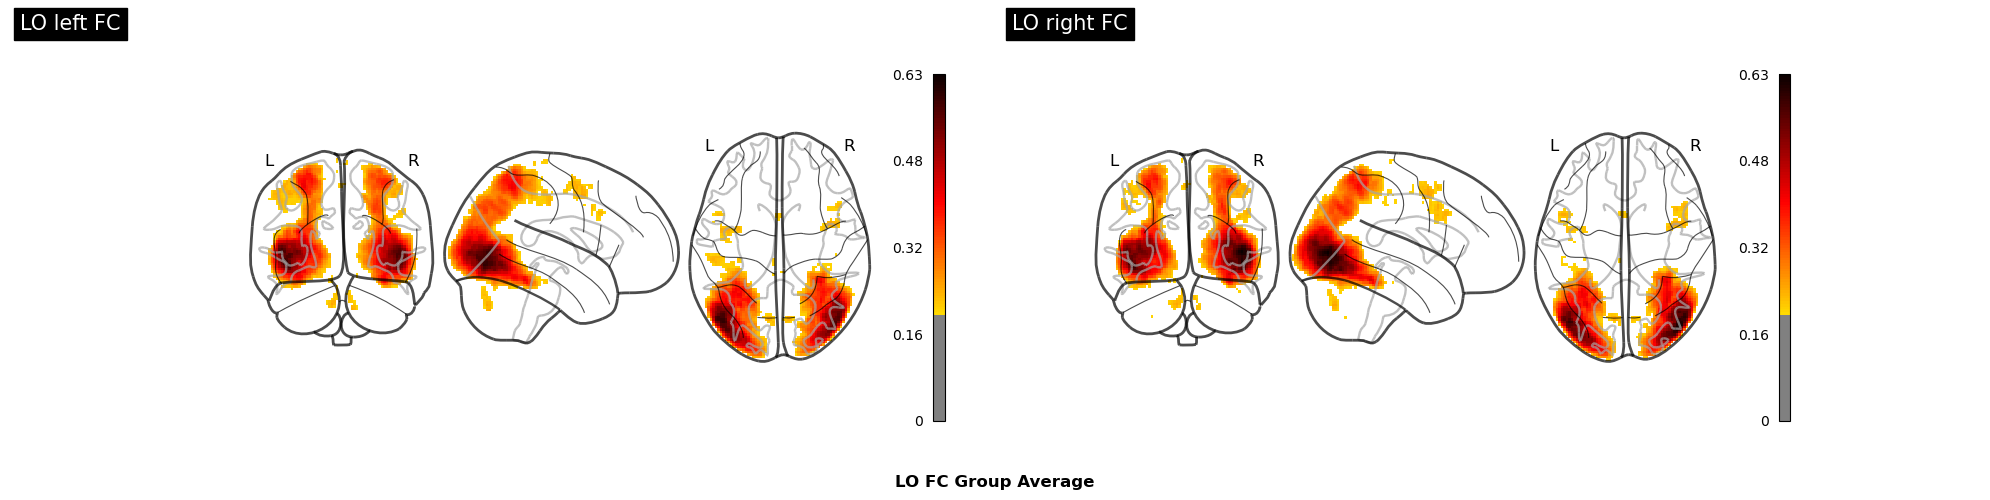

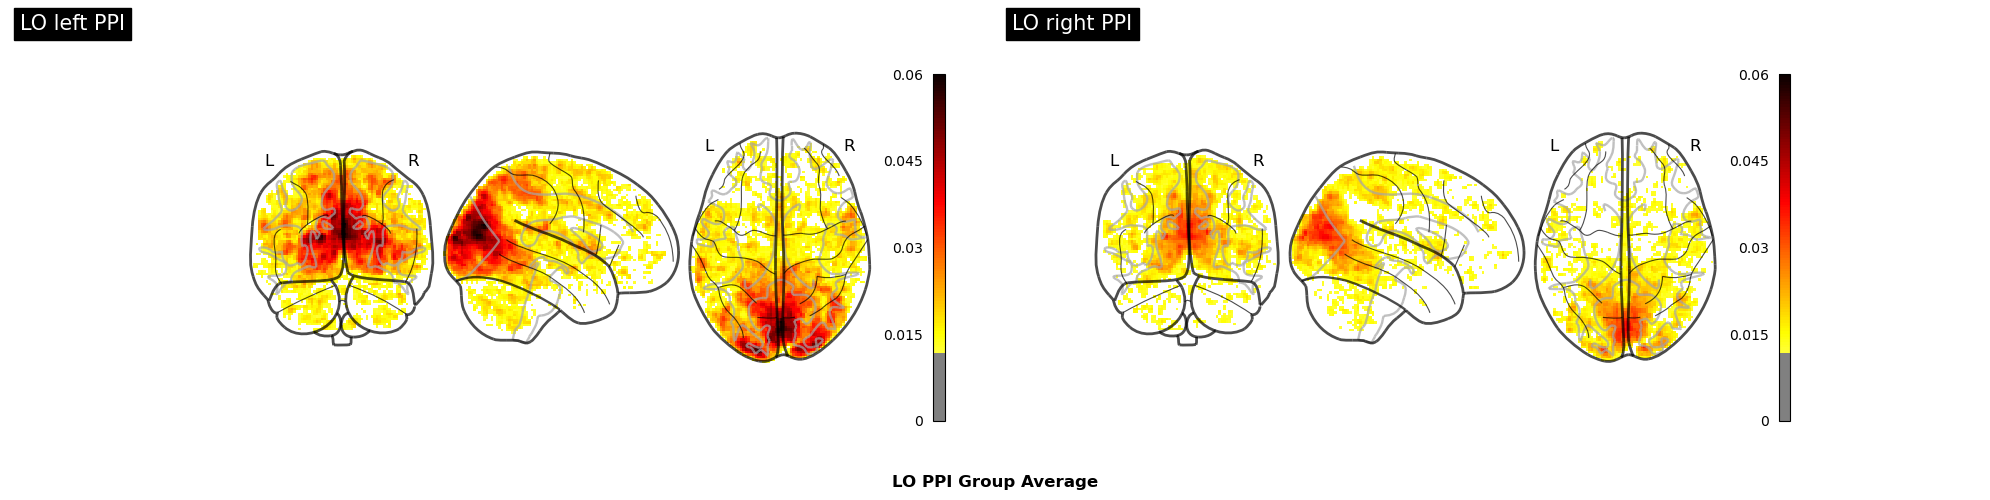

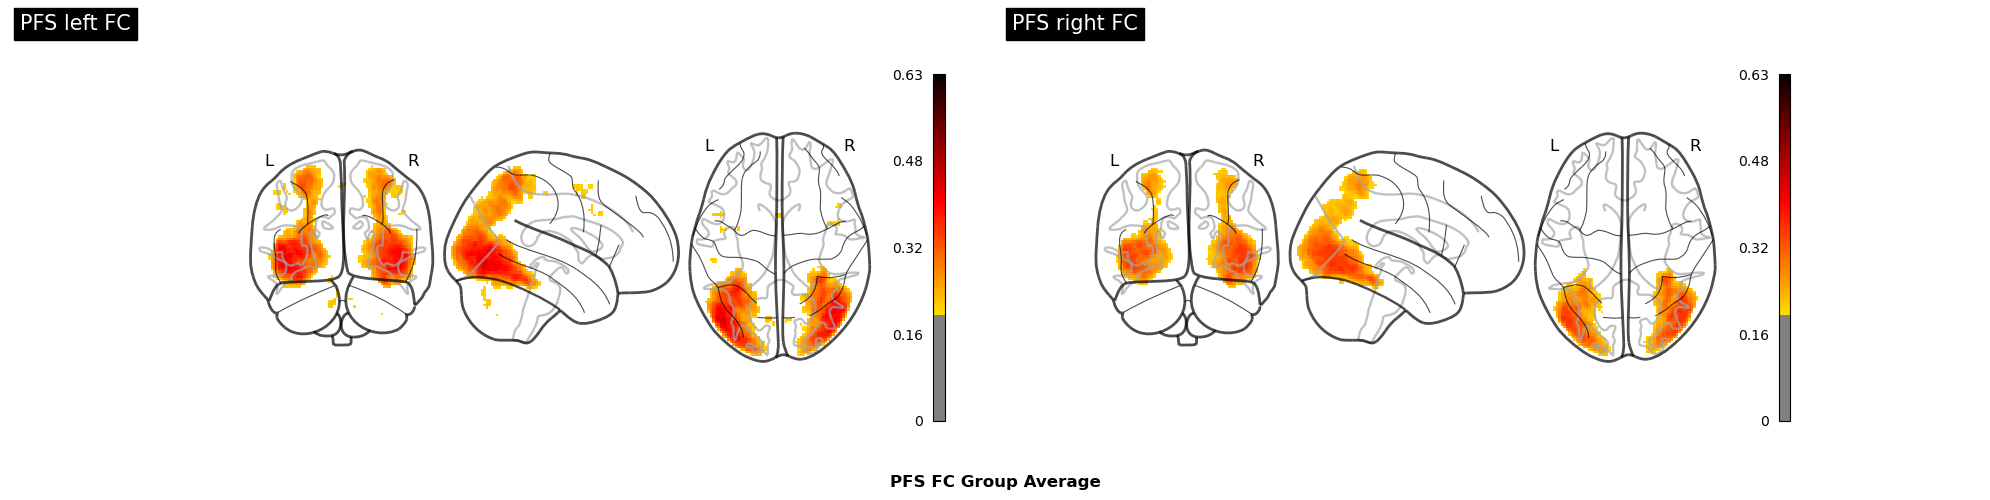

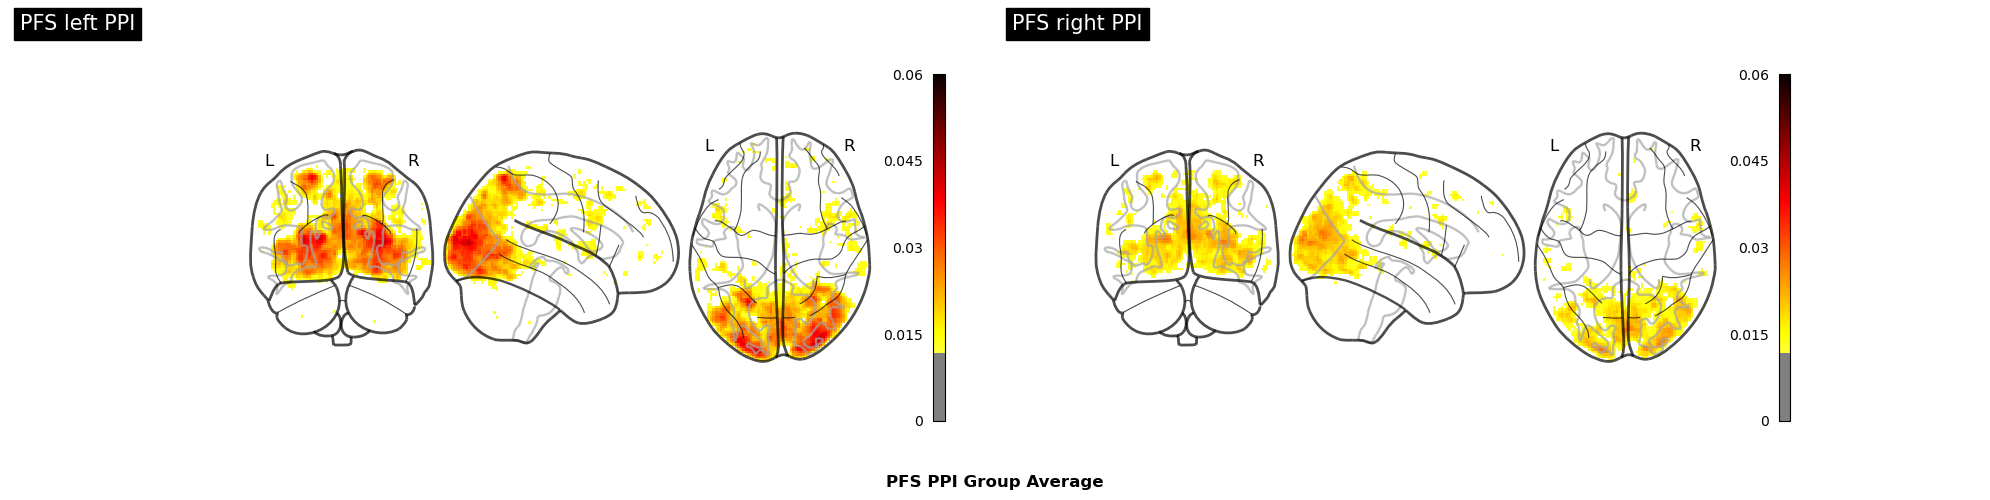

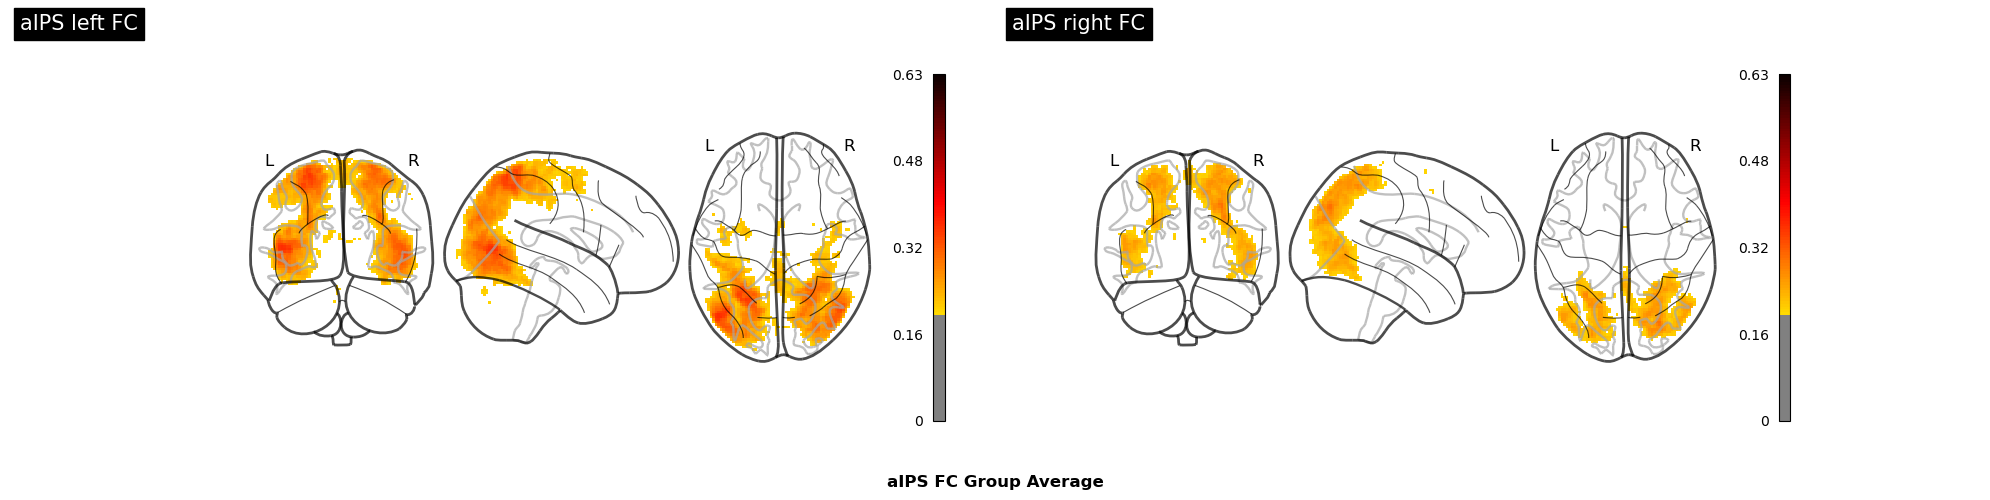

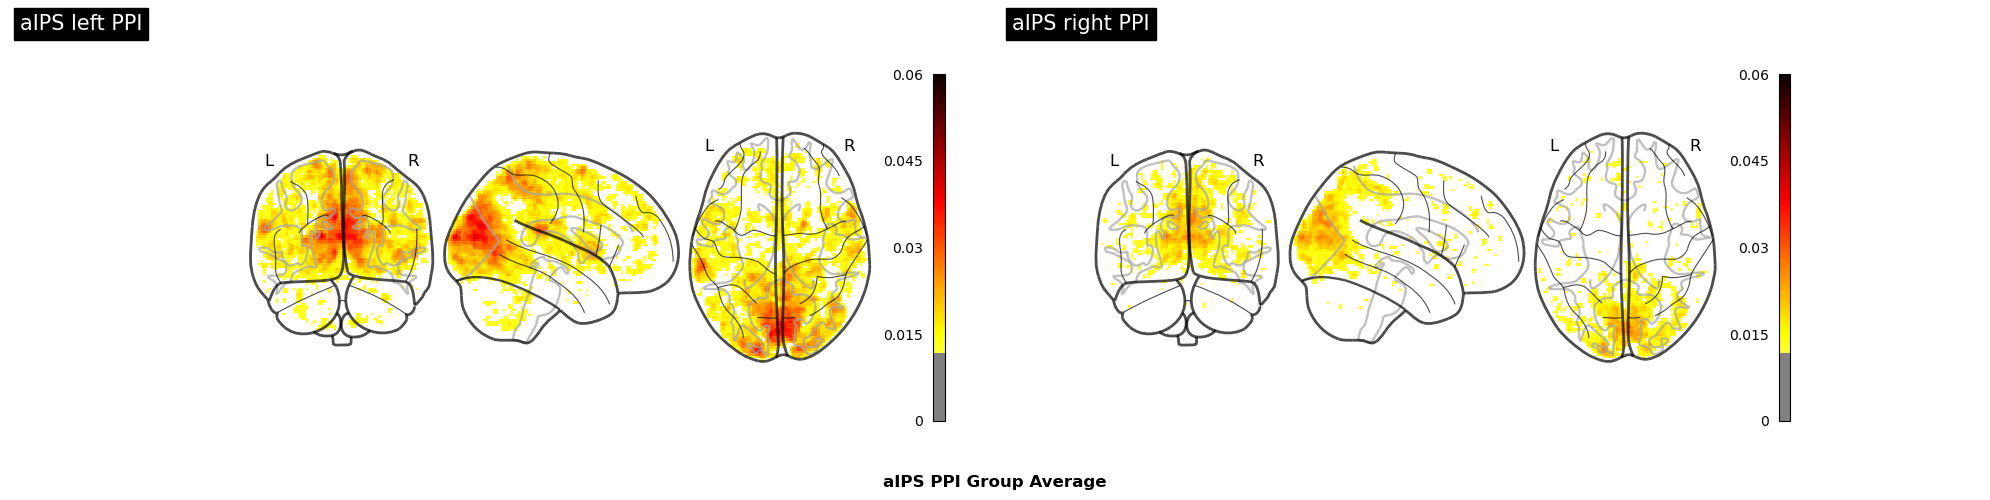

In [4]:
## group average with hemisphere tool
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting
import matplotlib.pyplot as plt

# Define study directories
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'
curr_dir = '/user_data/csimmon2/git_repos/ptoc'

# Explicitly set the path to sub_info.csv
sub_info_path = f'{curr_dir}/sub_info_tool.csv'

# Define subjects and ROIs
sub_info = pd.read_csv(sub_info_path)
subs = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()
rois = ['pIPS', 'LO', 'PFS', 'aIPS']
hemispheres = ['left', 'right']

def create_group_averages(subs, rois, hemispheres, out_dir):
    for roi in rois:
        for hemi in hemispheres:
            for analysis_type in ['fc', 'ppi']:
                all_sub_imgs = []
                for sub in subs:
                    # Construct path for each subject's file
                    img_file = f"{study_dir}/{sub}/ses-01/derivatives/fc/{sub}_{roi}_{hemi}_ToolLoc_{analysis_type}_mni.nii.gz"
                    
                    if os.path.exists(img_file):
                        all_sub_imgs.append(image.load_img(img_file))
                    else:
                        print(f"Warning: File not found for {sub}, {roi}, {hemi}, {analysis_type}")
                
                if all_sub_imgs:
                    # Create and save average image if files were found
                    avg_img = image.mean_img(all_sub_imgs)
                    out_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                    nib.save(avg_img, out_file)
                    print(f"Successfully saved group average for {roi} {hemi} {analysis_type}")
                else:
                    print(f"No images found for {roi} {hemi} {analysis_type}")

def plot_group_averages(out_dir, rois, hemispheres):
    # Calculate separate max values for FC and PPI
    fc_max = 0
    ppi_max = 0
    
    # Find maximum values across all ROIs and hemispheres
    for roi in rois:
        for hemi in hemispheres:
            # Get FC max
            img_file = f'{out_dir}/{roi}_{hemi}_fc_avg.nii.gz'
            if os.path.exists(img_file):
                data = nib.load(img_file).get_fdata()
                fc_max = max(fc_max, np.abs(data).max())
            
            # Get PPI max
            img_file = f'{out_dir}/{roi}_{hemi}_ppi_avg.nii.gz'
            if os.path.exists(img_file):
                data = nib.load(img_file).get_fdata()
                ppi_max = max(ppi_max, np.abs(data).max())

    # Create plots for each ROI
    for roi in rois:
        for analysis_type in ['fc', 'ppi']:
            fig, axes = plt.subplots(1, 2, figsize=(20, 5))
            
            # Set max value and threshold based on analysis type
            if analysis_type == 'fc':
                vmax = fc_max
                threshold = 0.2
            else:
                vmax = ppi_max
                threshold = 0.012
            
            for i, hemi in enumerate(hemispheres):
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    display = plotting.plot_glass_brain(
                        img_file, 
                        threshold=threshold,
                        colorbar=True,
                        vmax=vmax, 
                        vmin=-vmax,
                        title=f'{roi} {hemi} {analysis_type.upper()}',
                        axes=axes[i],
                        display_mode='ortho'
                    )
            
            plt.tight_layout()
            fig.text(0.5, 0.01, f'{roi} {analysis_type.upper()} Group Average', 
                     ha='center', va='bottom', fontsize=12, fontweight='bold')
            plt.subplots_adjust(bottom=0.15)
            #plt.savefig(f'{out_dir}/{roi}_{analysis_type}_group_average.png', dpi=300, bbox_inches='tight')
            #plt.close()

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    #os.makedirs(group_out_dir, exist_ok=True)

    # Create group averages
    #create_group_averages(subs, rois, hemispheres, group_out_dir)

    # Plot group averages
    plot_group_averages(group_out_dir, rois, hemispheres)

if __name__ == "__main__":
    main()

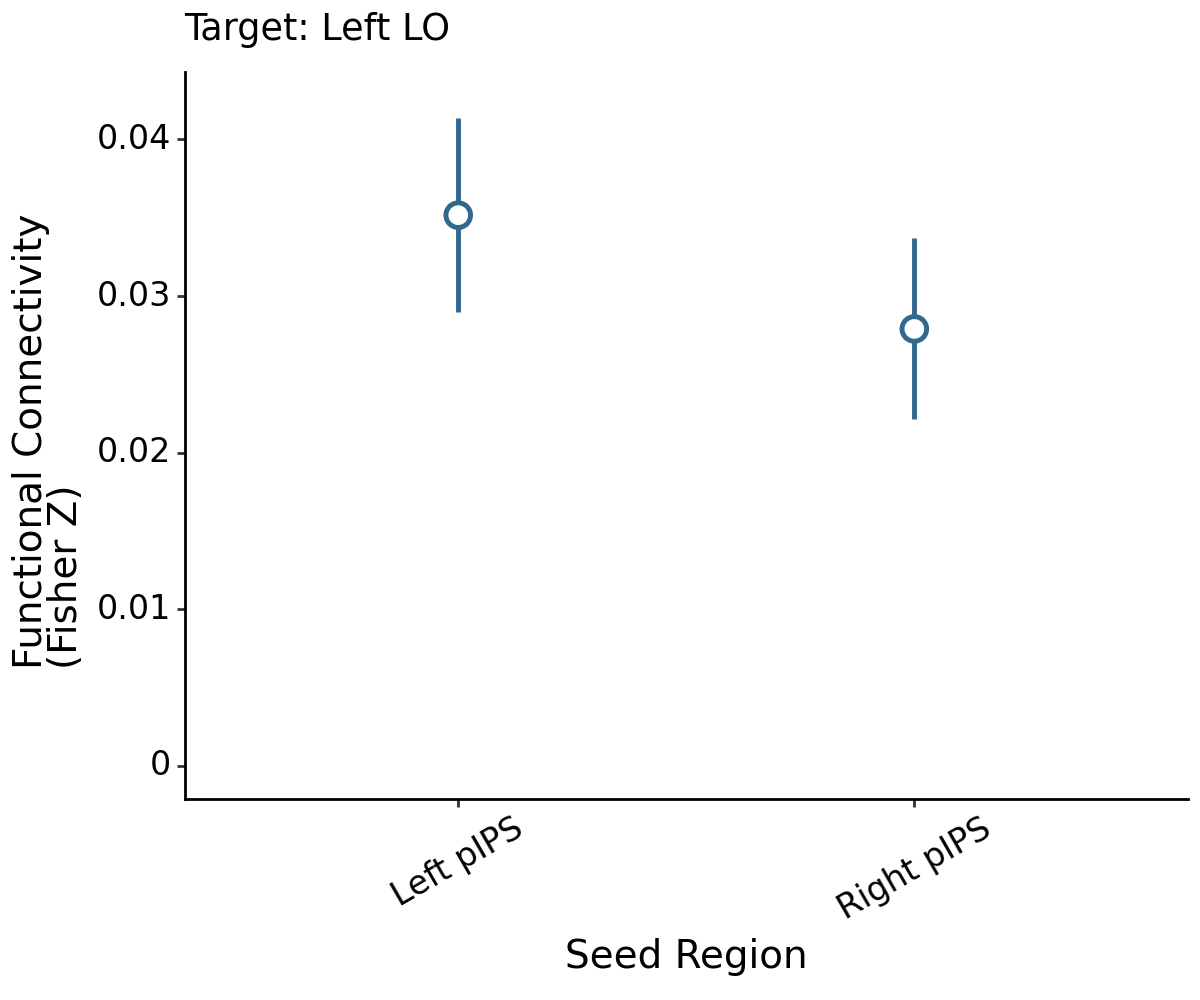

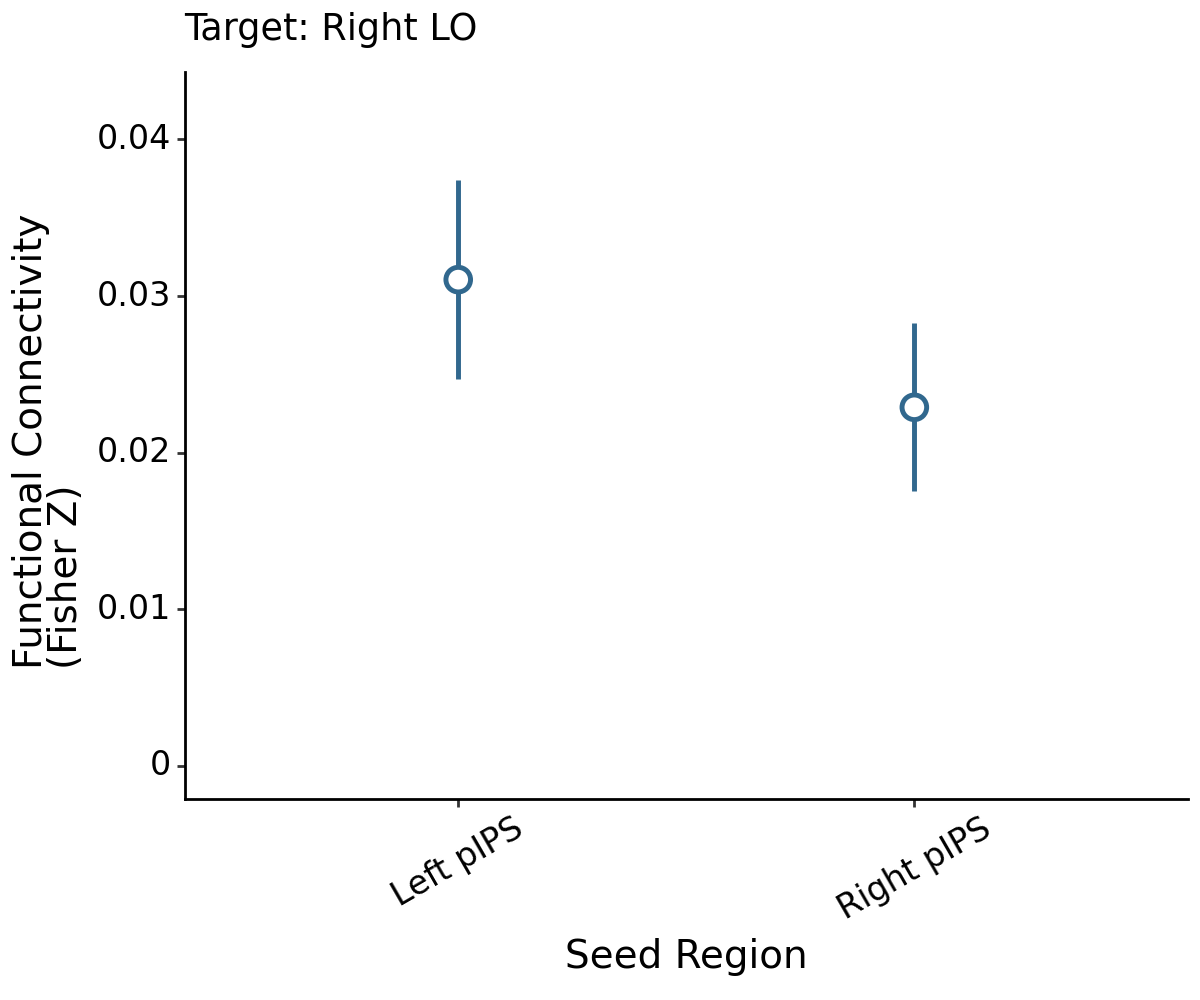

In [2]:
# code for plotting statistical results.
#corrected to seed to target see - matchvlad_seed_target_activations.csv
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_linerange, geom_point, ylim, theme_classic, xlab, ylab, scale_color_manual, theme, element_text, element_line, element_blank, facet_wrap, ggtitle

# Define variables
analysis = 'ppi'#'fc'
#analysis = 'fc'
results_dir = "results"  # Update this to your actual results directory

# Read the data
df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")

# Filter for the 'loc' task and 'ppi' analysis
df_filtered = df[(df['task'] == 'loc') & (df['analysis'] == 'ppi')]
#df_filtered = df[(df['task'] == 'loc') & (df['analysis'] == 'fc')]

# Create seed and target columns
df_filtered['seed'] = df_filtered['seed_hemisphere'] + '_' + df_filtered['seed_roi']
df_filtered['target'] = df_filtered['target_hemisphere'] + '_' + df_filtered['target_roi']

# Apply Fisher z-transform
df_filtered['fisher_z'] = np.arctanh(df_filtered['mean_activation'])

# Group by seed and target, calculate mean and standard error of Fisher z values
summary_df = df_filtered.groupby(['seed', 'target'])['fisher_z'].agg(['mean', 'sem']).reset_index()

# Rename columns
summary_df.columns = ['Seed', 'Target', 'FC', 'SE']

# Add LOC column for seeds
summary_df['LOC'] = 'posterior'  # All seeds are pIPS, which is posterior

# Rename ROIs for better readability
seed_mapping = {
    'left_pIPS': 'Left pIPS',
    'right_pIPS': 'Right pIPS'
}
target_mapping = {
    'left_LO': 'Left LO',
    'right_LO': 'Right LO'
}
summary_df['Seed'] = summary_df['Seed'].map(seed_mapping)
summary_df['Target'] = summary_df['Target'].map(target_mapping)

# Set Seed as categorical
summary_df['Seed'] = pd.Categorical(summary_df['Seed'], categories=['Left pIPS', 'Right pIPS'], ordered=False)

# Function to create plot for a specific target
def create_plot(data, target):
    plot = (ggplot(data[data['Target'] == target], aes(x='Seed', y='FC', color='LOC'))
            + geom_linerange(aes(ymax='FC + SE', ymin='FC - SE'), size=1)
            + geom_point(shape='o', size=4, fill='white', stroke=1)
            + ylim(0, data['FC'].max() * 1.2)  # Adjust ylim based on data
            + theme_classic()
            + xlab('Seed Region')
            + ylab('Functional Connectivity \n(Fisher Z)')
            + scale_color_manual(values=['#31688E'])
            + theme(
                text=element_text(color='black'),
                axis_text_x=element_text(angle=30, size=12),
                axis_text_y=element_text(size=12),
                axis_title=element_text(size=14),
                axis_line=element_line(),
                panel_border=element_blank(),
                legend_position="none",
                figure_size=(6, 5)
            )
            + ggtitle(f'Target: {target}'))
    return plot

# Create and print plots
left_lo_plot = create_plot(summary_df, 'Left LO')
right_lo_plot = create_plot(summary_df, 'Right LO')

print(left_lo_plot)
print(right_lo_plot)

# Optionally, save the plots
left_lo_plot.save("left_lo_ppi_plot.png", dpi=300)
right_lo_plot.save("right_lo_ppi_plot.png", dpi=300)

In [4]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiSpheresMasker
from nilearn import image
import sys
import time
import warnings
warnings.filterwarnings('ignore')

# Import parameters and set up directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ToolLoc'
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
raw_dir = params.raw_dir

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info_tool.csv')
subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()

# Define analysis parameters
rois = ['pIPS', 'LO', 'PFS', 'aIPS']  # Updated ROIs
hemispheres = ['left', 'right']
analyses = ['ppi']
tasks = ['ToolLoc']  # Updated task

def create_roi_masker(coords):
    return NiftiSpheresMasker([tuple(coords)], radius=6)

def extract_mean_activation(results_img, roi_masker):
    roi_data = roi_masker.fit_transform(results_img)
    return np.mean(roi_data)

def process_subjects():
    results = []
    
    for subject in subjects:
        print(f"Processing subject: {subject}")
        
        # Load ROI coordinates
        roi_coords = pd.read_csv('/user_data/csimmon2/git_repos/ptoc/tools/roi_coordinates.csv')
        # Filter coordinates for current subject - using the full subject ID format
        subject_coords = roi_coords[roi_coords['subject'] == subject]
        
        if subject_coords.empty:
            print(f"No coordinates found for subject: {subject}")
            continue
        
        # Process each seed ROI
        for seed_roi in rois:
            # Create ROI maskers for target ROIs
            target_maskers = {}
            for hemisphere in hemispheres:
                for task in tasks:
                    # Match the hemisphere format (convert 'left'/'right' to 'l'/'r')
                    hemi_prefix = 'l' if hemisphere == 'left' else 'r'
                    roi_name = f"{hemi_prefix}{seed_roi}"
                    
                    curr_coords = roi_coords[
                        (roi_coords['task'] == task) & 
                        (roi_coords['roi'] == roi_name)
                    ]
                    
                    if curr_coords.empty:
                        print(f"No coordinates found for {subject}, {roi_name}, {task}")
                        continue
                    
                    coords = curr_coords[['x', 'y', 'z']].values.tolist()[0]
                    target_maskers[(hemisphere, task)] = create_roi_masker(coords)
            
            # Process each analysis type
            for analysis in analyses:
                for seed_hemisphere in hemispheres:
                    for task in tasks:
                        # Construct filename with correct subject ID format
                        seed_file = f"{subject}_{seed_roi}_{seed_hemisphere}_{task}_{analysis}_mni.nii.gz"
                        full_seed_path = os.path.join(study_dir, f"{subject}", 'ses-01', 'derivatives', 'fc', seed_file)
                        
                        if not os.path.exists(full_seed_path):
                            print(f"No {analysis} results file found for {subject}, {seed_roi}, {seed_hemisphere}, {task}")
                            continue
                        
                        # Load the seed results image
                        seed_img = nib.load(full_seed_path)
                        
                        # Extract mean activation for all target ROIs
                        for target_roi in rois:
                            for target_hemisphere in hemispheres:
                                target_masker = target_maskers.get((target_hemisphere, task))
                                if target_masker is None:
                                    print(f"No target masker found for {subject}, {target_roi}, {target_hemisphere}, {task}")
                                    continue
                                
                                # Extract mean activation
                                mean_activation = extract_mean_activation(seed_img, target_masker)
                                
                                # Store the results
                                results.append({
                                    'subject': subject,
                                    'seed_roi': seed_roi,
                                    'seed_hemisphere': seed_hemisphere,
                                    'target_roi': target_roi,
                                    'target_hemisphere': target_hemisphere,
                                    'task': task,
                                    'analysis': analysis,
                                    'mean_activation': mean_activation
                                })
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    
    # Save the results to a CSV file
    output_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools/ppi'
    # Create the directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, 'tool_seed_target_activations.csv')
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

# Run the processing
if __name__ == "__main__":
    process_subjects()

Processing subject: sub-spaceloc1001
Processing subject: sub-spaceloc1002
Processing subject: sub-spaceloc1003
Processing subject: sub-spaceloc1004
Processing subject: sub-spaceloc1005
Processing subject: sub-spaceloc1006
Processing subject: sub-spaceloc1007
Processing subject: sub-spaceloc1008
Processing subject: sub-spaceloc1009
Processing subject: sub-spaceloc1010
Processing subject: sub-spaceloc1011
Processing subject: sub-spaceloc1012
Processing subject: sub-spaceloc2013
Processing subject: sub-spaceloc2014
Processing subject: sub-spaceloc2015
Processing subject: sub-spaceloc2016
Processing subject: sub-spaceloc2017
Processing subject: sub-spaceloc2018
Results saved to /user_data/csimmon2/git_repos/ptoc/results/tools/ppi/tool_seed_target_activations.csv


In [37]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiSpheresMasker
from nilearn import image
import sys
import warnings
warnings.filterwarnings('ignore')

# Import parameters and set up directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools/ppi'
raw_dir = params.raw_dir

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info_tool.csv')
subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()

# Define ROIs
#dorsal_rois = ['pIPS', 'aIPS']
#ventral_rois = ['LO', 'PFS']
rois = ['pIPS', 'LO']
hemispheres = ['left', 'right']
tasks = ['ToolLoc']
analyses = ['ppi']

def create_roi_masker(coords):
    return NiftiSpheresMasker([tuple(coords)], radius=6)

def extract_mean_activation(results_img, roi_masker):
    roi_data = roi_masker.fit_transform(results_img)
    return np.mean(roi_data)

def process_subjects():
    results = []
    
    for subject in subjects:
        print(f"Processing subject: {subject}")
        
        # Load ROI coordinates
        roi_dir = f'{study_dir}/{subject}/ses-01/derivatives/rois' #check this
        roi_coords = pd.read_csv('/user_data/csimmon2/git_repos/ptoc/tools/roi_coordinates.csv')
        #subject_coords = roi_coords[roi_coords['subject'] == subject]
        
        # Create ROI maskers for target ROIs (LO)        
        target_maskers = {}
        for hemisphere in hemispheres:
            for task in tasks:
                # Update ROI name based on hemisphere
                roi_name = f"{'l' if hemisphere == 'left' else 'r'}LO"
                
                curr_coords = roi_coords[
                    (roi_coords['task'] == task) & 
                    (roi_coords['roi'] == roi_name)
                ]
                print(curr_coords)
                
                if curr_coords.empty:
                    print(f"No coordinates found for {subject}, {roi_name}, {task}")
                    continue
                
                coords = curr_coords[['x', 'y', 'z']].values.tolist()[0]
                target_maskers[(hemisphere, task)] = create_roi_masker(coords)
        
        # Process each analysis
        for analysis in analyses:
            results_dir = os.path.join(study_dir, subject, 'ses-01', 'derivatives', 'fc')
            
            # Use pIPS as seed
            for seed_hemisphere in hemispheres:
                for task in tasks:
                    seed_file = f"{subject}_pIPS_{seed_hemisphere}_{task}_{analysis}_mni.nii.gz"
                    full_seed_path = os.path.join(results_dir, seed_file)
                    
                    if not os.path.exists(full_seed_path):
                        print(f"No {analysis} results file found for {subject}, pIPS, {seed_hemisphere}, {task}")
                        continue
                    
                    # Load the seed results image
                    seed_img = nib.load(full_seed_path)
                    
                    # Extract mean activation in target ROIs (LO)
                    for target_hemisphere in hemispheres:
                        target_masker = target_maskers.get((target_hemisphere, task))
                        if target_masker is None:
                            print(f"No target masker found for {subject}, LO, {target_hemisphere}, {task}")
                            continue
                        
                        # Extract mean activation
                        mean_activation = extract_mean_activation(seed_img, target_masker)
                        
                        # Store the results
                        results.append({
                            'subject': subject,
                            'seed_roi': 'pIPS',
                            'seed_hemisphere': seed_hemisphere,
                            'target_roi': 'LO',
                            'target_hemisphere': target_hemisphere,
                            'task': task,
                            'analysis': analysis,
                            'mean_activation': mean_activation
                        })
    
    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)
    
    # Save the results to a CSV file
    output_file = os.path.join(results_dir, 'seed_target_activations.csv')
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

# Run the processing
if __name__ == "__main__":
    process_subjects()

Processing subject: sub-spaceloc1001
               subject  run_combo     task        condition  roi hemisphere  \
2     sub-spaceloc1001          0  ToolLoc            tools  lLO          l   
10    sub-spaceloc1001          0  ToolLoc         scramble  lLO          l   
18    sub-spaceloc1001          0  ToolLoc         nontools  lLO          l   
26    sub-spaceloc1001          0  ToolLoc  toolovernontool  lLO          l   
34    sub-spaceloc1001          0  ToolLoc  nontoolovertool  lLO          l   
...                ...        ...      ...              ...  ...        ...   
1402  sub-spaceloc2018          1  ToolLoc            tools  lLO          l   
1410  sub-spaceloc2018          1  ToolLoc         scramble  lLO          l   
1418  sub-spaceloc2018          1  ToolLoc         nontools  lLO          l   
1426  sub-spaceloc2018          1  ToolLoc  toolovernontool  lLO          l   
1434  sub-spaceloc2018          1  ToolLoc  nontoolovertool  lLO          l   

              